# <font color='darkblue'> THE NETWORK OF BEATLES' SONGS

## <font color='darkblue'>Analysis of the network of Beatles'Songs: Getting into their mind

In [2]:
#We import all the necessary packages we used for this project

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import ast
import operator
import powerlaw
from fa2 import ForceAtlas2
import re
from urllib.request import urlopen
import urllib.request as urllib2
import os
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import community.community_louvain
import matplotlib.cm as cm

In [5]:
#Import data

Song_data=pd.read_csv('Songs_Sorted_Years.csv')
Song_data

Song  Year     Month  Day Lyrics
0                      love-me-do  1962   October    5    Yes
1                   ps-i-love-you  1962   October    5    Yes
2                      ask-me-why  1963   January   11    Yes
3                please-please-me  1963   January   11     No
4                     taste-honey  1963     March   22     No
..                            ...   ...       ...  ...    ...
296              you-know-what-do  2012  December   14    Yes
297  you-never-give-me-your-money  2012  December   14    Yes
298                sie-liebt-dich  2013  February    7    Yes
299                     slow-down  2013  February    7     No
300               you-me-too-much  2013       May   16    Yes

[301 rows x 5 columns]

###  <font color='darkblue'>Part 1: Clean Lyrics of Songs.

In [7]:
stop_words = list(set(stopwords.words('english')))
stop_words = [el.replace('\'','') for el in stop_words]
stop_words.append('im')

<font color='darkblue'> A function to **clean the lyrics** is built.

In [8]:
def clean_lyrics(file_path):
    data=open(file_path).read()
    # import WordPunctTokenizer() method from nltk
    # Create a reference variable for Class WordPunctTokenizer
    tk = WordPunctTokenizer()
    # define punctuation
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    # remove punctuation from the string
    no_punct = ""
    for char in data:
        if char not in punctuations:
            no_punct = no_punct + char
    # Remove all the special characters as \n and single = left
    char=['\n','=']
    for el in char:
        raw=re.sub(el,'',no_punct)
    # remove stop words
    token_txt = tk.tokenize(raw.lower()) # set to lower case
    token_txt = tk.tokenize(raw.lower()) # set to lower case
    token_final = [x for x in token_txt if x not in stop_words and len(x)>2]
    return token_final

In [9]:
lyrics_files=[el[:-4] for el in os.listdir('lyrics_songs')]
lyrics_files.remove('.DS_S') # remove this element that is introduced when using os.listdir

###  <font color='darkblue'>Part 2: Build the Network.

In [10]:
#After cleaning the lyrics of songs, we found the first five most common words in each song. 
#d_top5 is a dictionary with the most common words used for each song. 
d_top5={}
for file in lyrics_files:
    path='lyrics_songs/'+file+'.txt'
    clean=clean_lyrics(path)
    
    top5=[]
    for el in FreqDist(clean).most_common(5):
        top5.append(el[0])
    d_top5[file]=top5

In [12]:
hyperlinks={} #dictionary to store links 

for file1 in lyrics_files:
    eq_files=[]
    for file2 in lyrics_files:
        if file1!=file2:
            a=d_top5[file1]
            b=d_top5[file2]
            # compute if there are equal words in both lists
            eq=0
            
            for el in a:
                if el in b:
                    eq+=1
            if eq!=0:
                eq_files.append(file2)
                
    idx1=Song_data[Song_data['Song']==file1].index[0]

    eq_files_later=[]

    for eq in eq_files:
        idx2=Song_data[Song_data['Song']==eq].index[0]
        if idx1<idx2: # means that file1 song was released earlier
            eq_files_later.append(eq)
            
    hyperlinks[file1]=eq_files_later


<font color='darkblue'> With the links stored, we are able to build the directed Graph based on the date release of the corresponding songs. 

In [13]:
#We build the Directed Network
Beatles_nw= nx.DiGraph()
for file in lyrics_files:
    #We add the nodes and attributes to the the network
    file=file.replace('-',' ')
    Beatles_nw.add_node(file)

#We add the hyperlinks to the the network
for el in lyrics_files:
    links= hyperlinks[el]
    for a in links:
        u= el
        v= a
        u=u.replace('-',' ')
        v=v.replace('-',' ')
        Beatles_nw.add_edge(u,v)

<font color='darkblue'> Next, we extract the **GCC** subgraph of the Beatles network.

In [14]:
Gs = list(Beatles_nw.subgraph(c).copy() for c in nx.weakly_connected_components(Beatles_nw))
biggest = 0
GCC_index = 0
for index,graph in enumerate(Gs):
    if len(graph.nodes) > biggest:
        biggest = len(graph.nodes)
        GCC_index = index
GCC = Gs[GCC_index]

In [15]:
print('- Considering the GCC of the Beatles Network, it has',len(GCC.nodes()),'number of nodes and',
      len(GCC.edges.data()),'number of links.')

- Considering the GCC of the Beatles Network, it has 195 number of nodes and 2619 number of links.


###  <font color='darkblue'>Part 3: Visualize the Network.

In [16]:
# Determing node size depending on the degree of each node. 
degree=[el *15 for el in list(dict(GCC.out_degree()).values())]


#Specifying Labels
highest_degree = dict(sorted(GCC.out_degree, key=lambda x: x[1], reverse=True)[0:20])
labels_draw = list(highest_degree.keys())
labels = {}    
for node in GCC.nodes():
    if node in labels_draw:
        labels[node] = node


In [17]:
#Get node positions based on the Force Atlas 2 algorithm 
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.5,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.01,#1 before - 0.01 after
                        strongGravityMode=False,#False  before - true after
                        gravity=10, #1.0 before -1.5 after

                        # Log
                        verbose=False) #True before - false after

#getting node positions
positions = forceatlas2.forceatlas2_networkx_layout(GCC, pos=None, iterations=300)



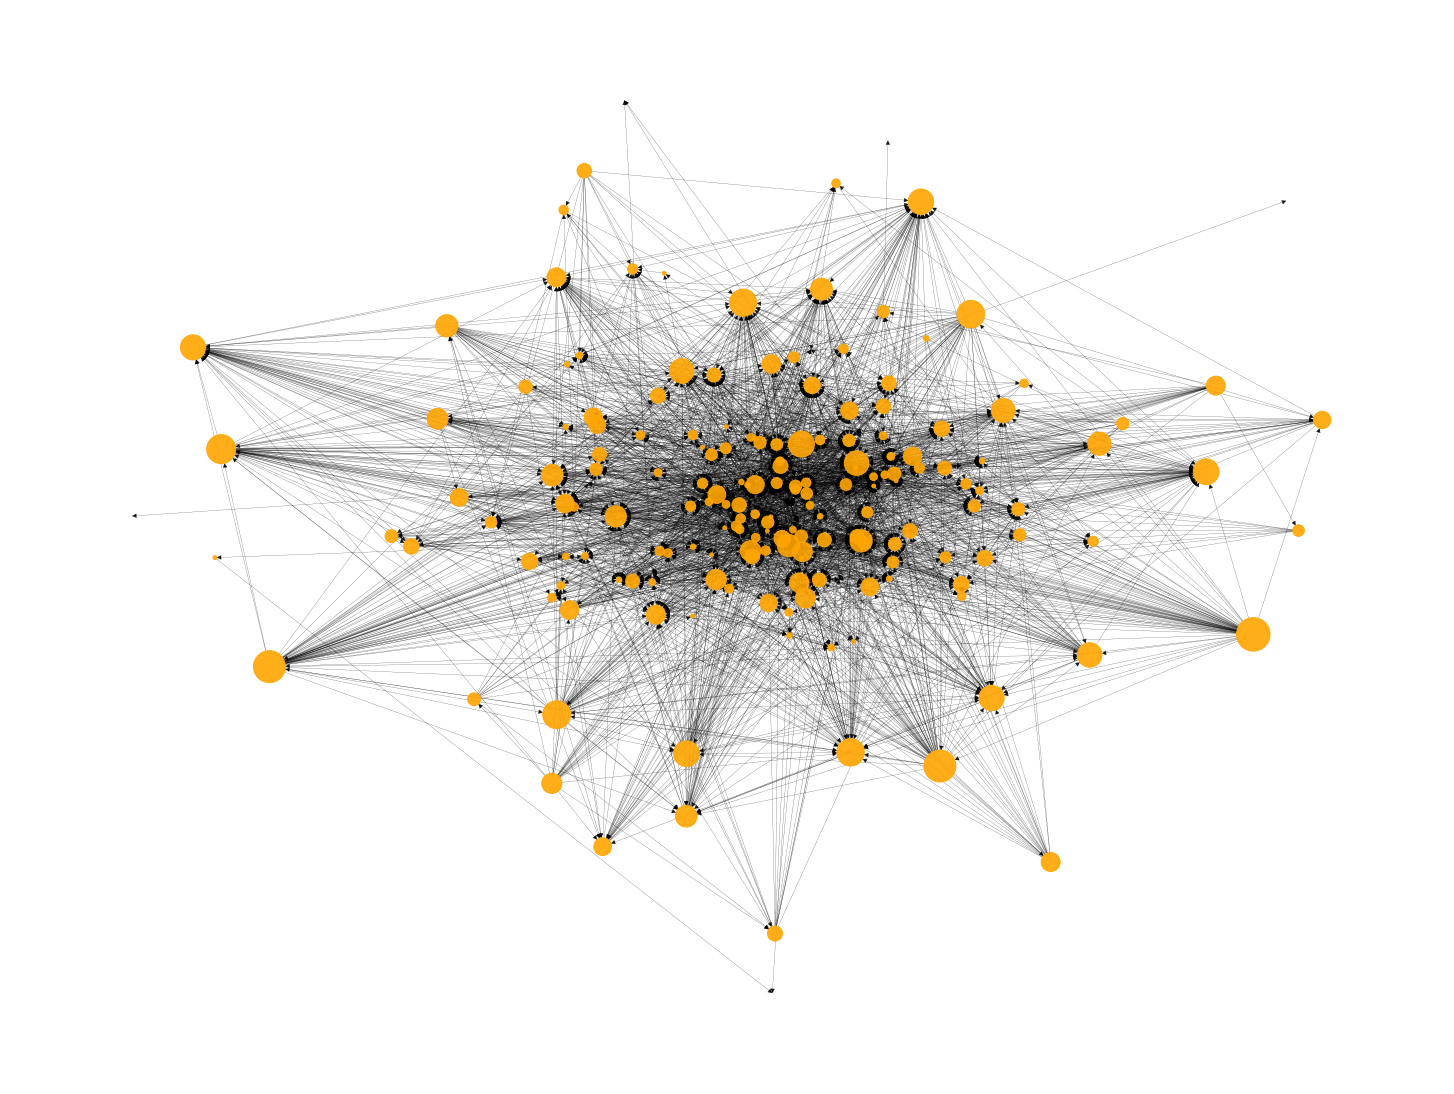

In [18]:
#VISUALIZATION
options = {
    'node_size': degree,
    'width': 0.2,
    #'edge_color':edge_colors,
    'node_color': 'orange',
    #'labels':labels,
    'alpha':0.9
}

fig = plt.gcf()
nx.draw(GCC, positions,**options) 
fig.set_size_inches(20, 15)
#plt.savefig("Final_Graph.png")


####  <font color='darkblue'>Part 3.1: Create a Network Evolution by Time.

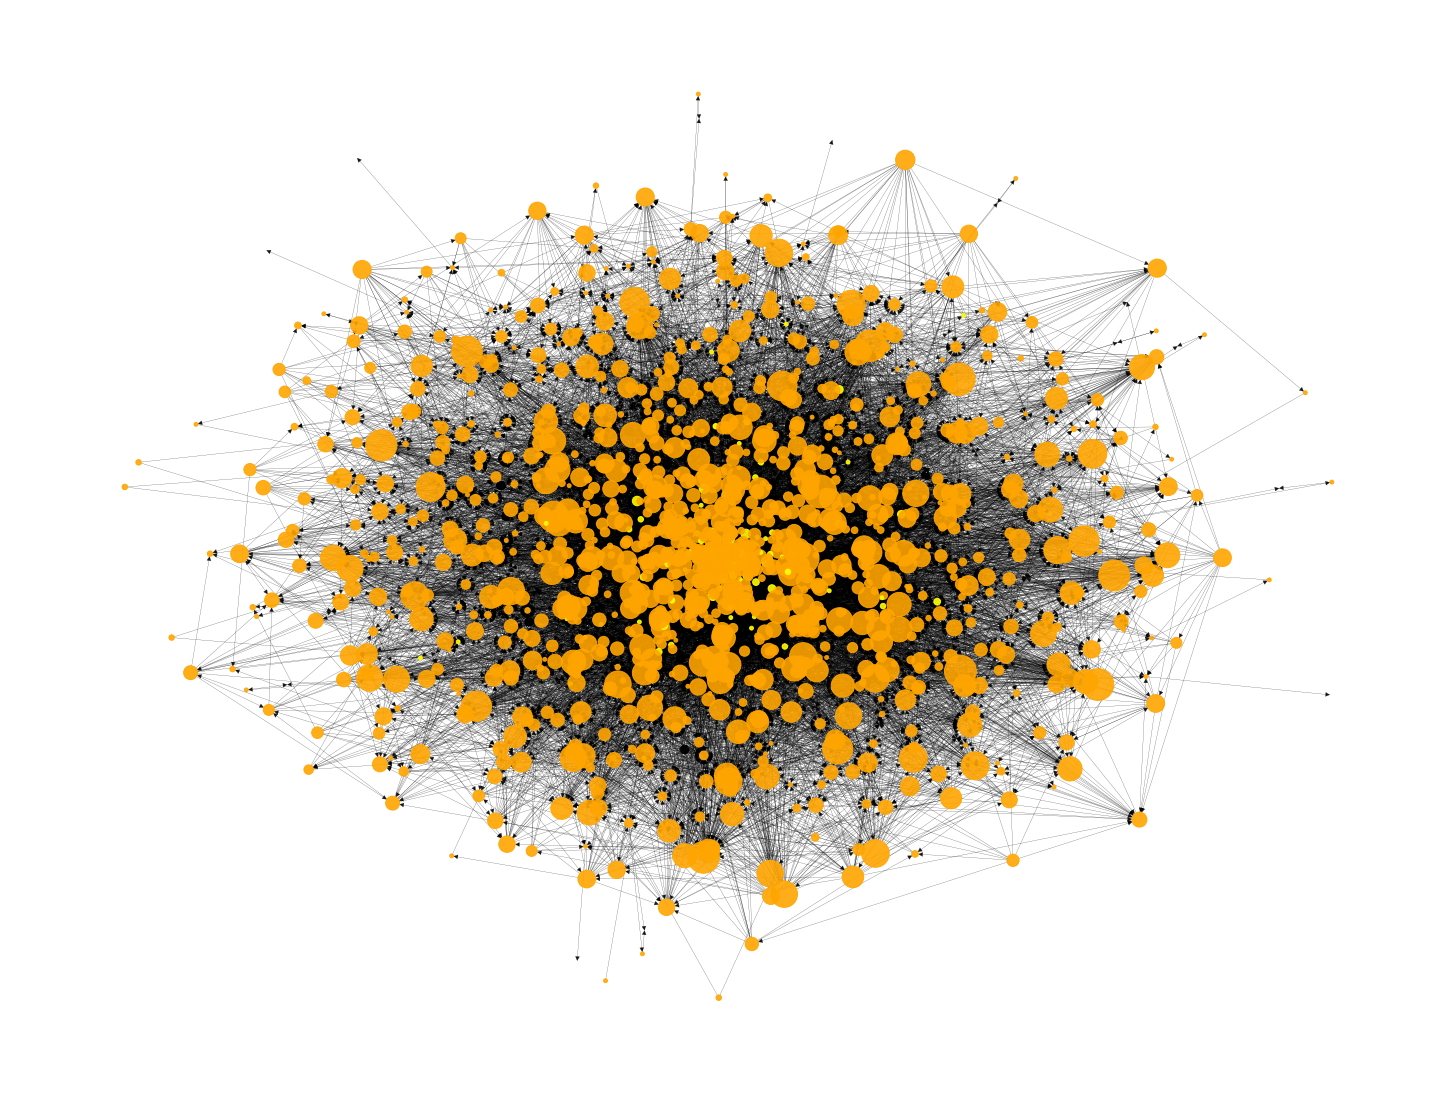

In [94]:
#Code for Network Evolution 
years=list(np.unique(list(Song_data['Year'])))[:-4]
lyrics_files=[]


for ind,year in enumerate(years):
    a=list(Song_data[Song_data['Year']==year]['Song'])
    new_lyrics_files=[]
    for el in a:
        lyrics_files.append(el)
        new_lyrics_files.append(el)
    
    hyperlinks={} #dictionary to store links 

    for file1 in lyrics_files:
        eq_files=[]
        for file2 in lyrics_files:
            if file1!=file2:
                try:
                    a=d_top5[file1]
                    b=d_top5[file2]
                    # compute if there are equal words in both lists
                    eq=0

                    for el in a:
                        if el in b:
                            eq+=1
                    if eq!=0:
                        eq_files.append(file2)
                except:
                    pass

        idx1=Song_data[Song_data['Song']==file1].index[0]

        eq_files_later=[]

        for eq in eq_files:
            idx2=Song_data[Song_data['Song']==eq].index[0]
            if idx1<idx2: # means that file1 song was released earlier
                eq_files_later.append(eq)

        hyperlinks[file1]=eq_files_later


    #build the network
    Beatles_nw= nx.DiGraph()
    for file in lyrics_files:
        #We add the nodes and attributes to the the network
        Beatles_nw.add_node(file)
    #We add the hyperlinks to the the network
    for el in hyperlinks:
        links= hyperlinks[el]
        for a in links:
            u= el
            v= a
            Beatles_nw.add_edge(u,v)

    Gs = list(Beatles_nw.subgraph(c).copy() for c in nx.weakly_connected_components(Beatles_nw))
    biggest = 0
    GCC_index = 0
    for index,graph in enumerate(Gs):
        if len(graph.nodes) > biggest:
            biggest = len(graph.nodes)
            GCC_index = index
    GCC = Gs[GCC_index]
    
    #Determining node color 
    map_color=[]
    for aa in GCC.nodes():
        if aa in new_lyrics_files:
            map_color.append('yellow')
        else:
            map_color.append('orange')
    
    # Determing node size depending on the degree of each node. 
    degree=[el *15 for el in list(dict(GCC.out_degree()).values())]
    
    
    #VISUALIZATION
    options = {
        'node_size': degree,
        'width': 0.2,
        'node_color': map_color,
        'alpha':0.9
    }
    
    #getting node positions
    positions = forceatlas2.forceatlas2_networkx_layout(GCC, pos=None, iterations=300)
    
    fig = plt.gcf()
    nx.draw(GCC,positions,**options)
    fig.set_size_inches(20, 15)
    #plt.savefig("Graph"+str(year)+".png")


####  <font color='darkblue'>Part 3.2: Statistical Analysis of the Network: In-degree and Out-degree Distributions. 

Text(0, 0.5, 'Count')

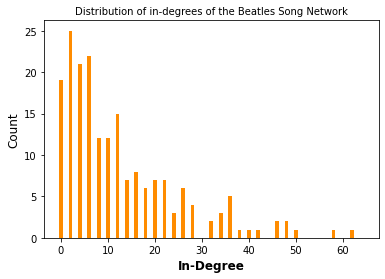

In [19]:
#Bar plot of the in-degree distribution
in_degrees = sorted(GCC.in_degree(GCC.nodes, weight=None), key=lambda x: x[1], reverse = True)
in_degrees_dist = [tuples[1] for tuples in in_degrees]
v1 = np.arange(int(min(in_degrees_dist )),int(max(in_degrees_dist)),2)

fig1 = plt.gcf()
count1,bins1=np.histogram(in_degrees_dist ,bins=v1)
plt.bar(bins1[:-1], count1,color='darkorange')
plt.title('Distribution of in-degrees of the Beatles Song Network',fontsize=10)
plt.xlabel('In-Degree',fontsize=12,fontweight='bold')
plt.ylabel('Count',fontsize=12)
#plt.savefig("In_degree.png")


Text(0, 0.5, 'Counts')

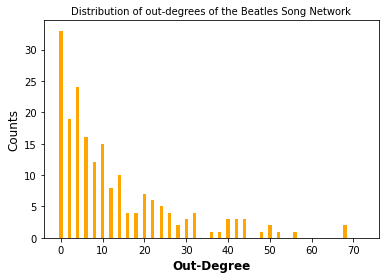

In [20]:
#Bar plot of the out-degree distribution
out_degrees = sorted(GCC.out_degree(GCC.nodes, weight=None), key=lambda x: x[1], reverse = True)
out_degrees_dist = [tuples[1] for tuples in out_degrees]

fig2 = plt.gcf()
v2 = np.arange(int(min(out_degrees_dist)),int(max(out_degrees_dist)),2)
count2,bins2=np.histogram(out_degrees_dist,bins=v2)
plt.bar(bins2[:-1], count2,color='orange')
plt.title('Distribution of out-degrees of the Beatles Song Network',fontsize=10)
plt.xlabel('Out-Degree',fontsize=12,fontweight='bold')
plt.ylabel('Counts',fontsize=12)
#plt.savefig("Out_degree.png")

###  <font color='darkblue'>Part 4: Find Communities

In [21]:
# Compute the best partition. We need to take into account the undirected graph. 
un_Beatles_nw= GCC.to_undirected()
partition = community.community_louvain.best_partition(un_Beatles_nw)

print('Number of communities found: ', len(np.unique(list(partition.values()))))

Number of communities found:  5


In [22]:
mod = community.community_louvain.modularity(partition, un_Beatles_nw)
print("The modularity value is:","{:.3f}".format(mod))

The modularity value is: 0.322


####  <font color='darkblue'>Visualize Communities:

In [23]:
node_community = [node[1] for node in partition.items()]
pCol = {i: list(np.random.random(size=3)) for i in set(node_community)}


The distribution of the community sizes


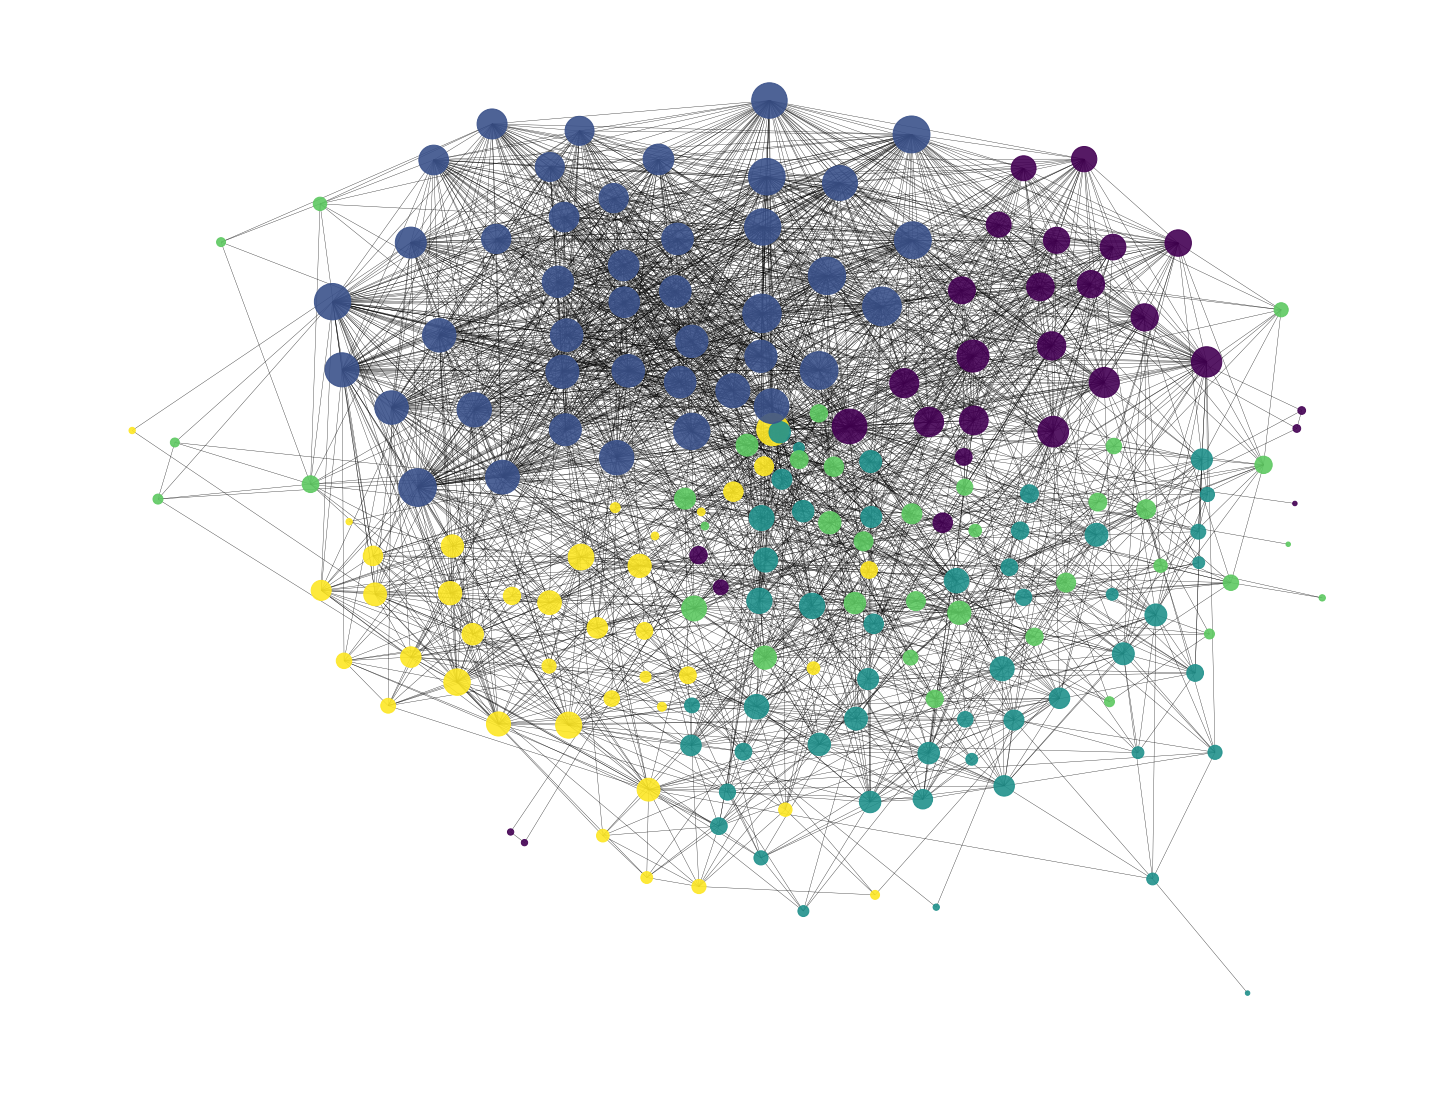

In [24]:
plt.figure(figsize=(30, 15))
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=2.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.1,
                        strongGravityMode=False,
                        gravity=10.0,

                        # Log
                        verbose=False)

positions = forceatlas2.forceatlas2_networkx_layout(un_Beatles_nw, pos=None, iterations=2000)
f = dict(nx.degree(un_Beatles_nw))
node_sizes = [v*20 for v in f.values()]
print("The distribution of the community sizes")
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
fig = plt.gcf()
nx.draw(un_Beatles_nw, positions, node_size=node_sizes, with_labels=False, width = 0.35, node_color=list(partition.values()), alpha=0.9)
fig.set_size_inches(20, 15)
#plt.savefig("Communities.png")

In [25]:
# We compute the number of songs in every community
#communities_d stores the group of songs in the same community
communities_d=dict.fromkeys(list(range(0,len(np.unique(list(partition.values()))))))
for i in range(0,len(np.unique(list(partition.values())))):
    l=[]
    for el in partition:
        if partition[el]==i:
            l.append(el)
    communities_d[i]=l
    
size_communities=[len(x) for x in communities_d.values()]

size_communities #number of songs in each community

[28, 42, 50, 36, 39]

<font color='darkblue'> Next, we extract the **most common words** in each community. 
    
    
- <font color='darkblue'> First, counting the number of times a word appears in each song of the community. 

In [26]:
for idx in communities_d:
    community_words=[]
    for el in communities_d[idx]:
        el=el.replace(' ','-')
        path='lyrics_songs/'+el+'.txt'
        clean=clean_lyrics(path)
        for word in clean:
            community_words.append(word)
    print(FreqDist(community_words).most_common(5))


[('know', 183), ('say', 50), ('name', 42), ('come', 37), ('lonely', 33)]
[('love', 314), ('know', 77), ('cant', 43), ('say', 43), ('ill', 41)]
[('ill', 86), ('yeah', 76), ('want', 75), ('baby', 74), ('like', 57)]
[('yeah', 101), ('got', 83), ('home', 66), ('ive', 52), ('let', 50)]
[('see', 85), ('girl', 75), ('ooh', 46), ('little', 45), ('time', 42)]


- <font color='darkblue'> Second, counting in how many songs of the community a word appear.  Below, a function is created for that purpose. 

In [27]:
for idx in communities_d:
    community_words=[]
    for el in communities_d[idx]:
        el=el.replace(' ','-')
        path='lyrics_songs/'+el+'.txt'
        clean=clean_lyrics(path)
        unique=list(np.unique(clean))
        for word in unique:
            community_words.append(word)
    print('size:' ,size_communities[idx])
    print(FreqDist(community_words).most_common(5))

size: 28
[('know', 21), ('love', 8), ('like', 8), ('man', 7), ('say', 7)]
size: 42
[('love', 42), ('know', 26), ('see', 17), ('want', 15), ('never', 12)]
size: 50
[('want', 19), ('ill', 19), ('know', 19), ('like', 17), ('see', 17)]
size: 36
[('got', 15), ('know', 13), ('time', 13), ('ive', 12), ('one', 12)]
size: 39
[('see', 21), ('time', 16), ('day', 14), ('like', 14), ('girl', 14)]


In [28]:
def community_words(community):
    community_words=[]
    for el in community:
        el=el.replace(' ','-')
        path='lyrics_songs/'+el+'.txt'
        clean=clean_lyrics(path)
        unique=list(np.unique(clean))
        for word in unique:
            community_words.append(word)
    return FreqDist(community_words).most_common(5)

community_words(communities_d[0])

[('know', 21), ('love', 8), ('like', 8), ('man', 7), ('say', 7)]

<font color='darkblue'> We were also interested in analyzing **in which community** the most famous songs belong.

In [29]:
def song_community(song):
    i=0
    for idx in communities_d:
        if song in communities_d[i]:
            return i
        i+=1
        
song_community('let it be')
community_words(communities_d[song_community('let it be')])

[('got', 15), ('know', 13), ('time', 13), ('ive', 12), ('one', 12)]

###  <font color='darkblue'>Part 5: VADER Sentimental Analysis